# Détection de plages

Ceci est un début de détection de plages à améliorer.

In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage import measure

import astropy.units as u
from astropy.table import QTable

from module import toSunpyMap, getWeights, medianFlatten

Les images utilisées ne sont pas disponibles dans ce répertoire, il faudra récupérer des images de test sur CLIMSO DB.

In [2]:
base_dir='/data/herrington/climso/calibrated/'

files = [base_dir+file for file in os.listdir(base_dir) if file.startswith('imoa_03933_l2_2024')]

In [3]:
file =  np.random.choice(files)
map = toSunpyMap(file, center_disk=True)

img = medianFlatten(map)
mask = np.zeros(map.data.shape, dtype=np.uint8)
cv.circle(mask, (1024,1024), int(map.meta['rsun_obs']-20), 1, thickness=-1)
img[mask==0]=np.nan

In [4]:
from matplotlib.colors import LinearSegmentedColormap
cmap_purple = LinearSegmentedColormap.from_list('dark_to_bright_red', ['#220022','#443044','#684055', '#9060A0', '#FFEEFF'])

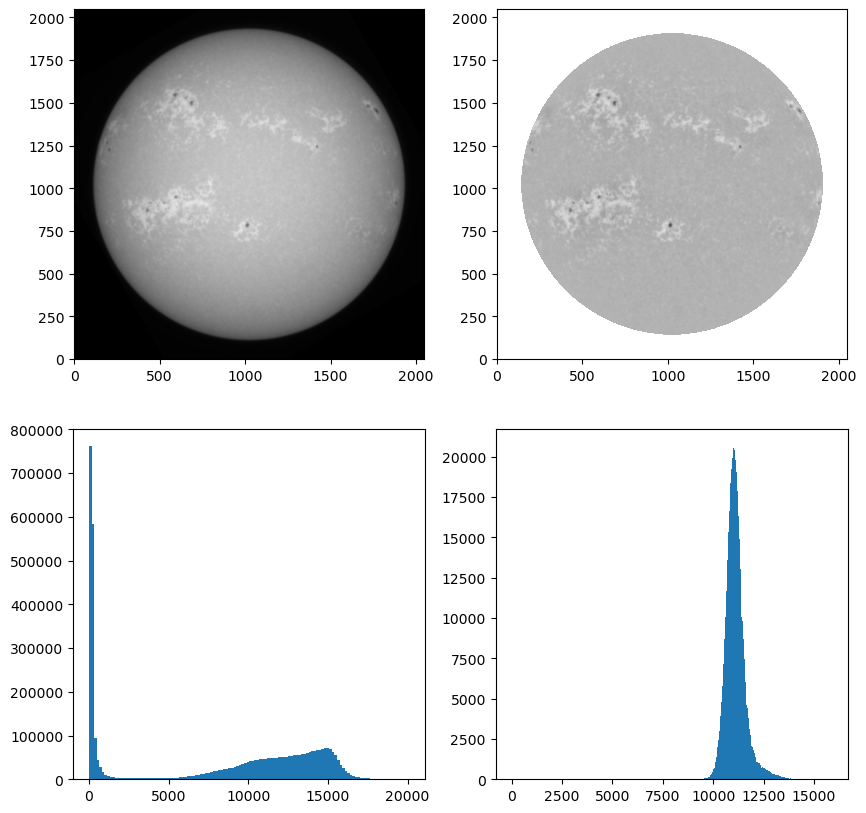

In [5]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(map.data, origin='lower', cmap='grey')

plt.subplot(222)
plt.imshow(img, origin='lower', cmap='grey')

plt.subplot(223)
plt.hist(map.data.flatten(), bins='auto');

plt.subplot(224)
plt.hist(img.flatten(), bins='auto');

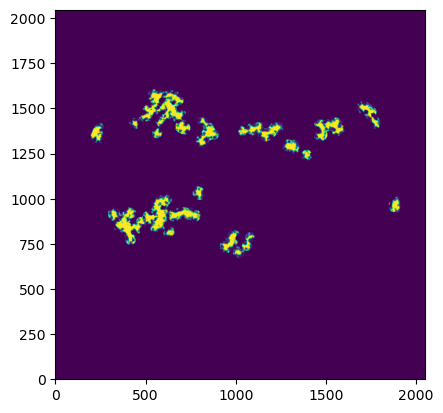

In [16]:
Ca = img > np.nanmedian(img)*1.05

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15))
Ca_large = cv.morphologyEx(Ca.astype(np.uint8), cv.MORPH_ERODE, kernel)

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(55,55))
Ca_large = cv.morphologyEx(Ca_large.astype(np.uint8), cv.MORPH_DILATE, kernel)

Ca = Ca*Ca_large

plt.imshow(Ca, origin='lower');

In [17]:
n_labels, labels = cv.connectedComponents(Ca_large, connectivity=8)

Ca_labels = Ca * labels

regions = measure.regionprops(Ca_labels)

radius = map.meta['RSUN_OBS']
weights, mu = getWeights(map)

num  = []
lat  = []
lon  = []
x    = []
y    = []
area = []

for r in regions:
    point = map.pixel_to_world(r.centroid[1]*u.pixel, r.centroid[0]*u.pixel).heliographic_stonyhurst
    lat.append(round(point.lat.deg, 2))
    lon.append(round(point.lon.deg, 2))
    
    num.append(r.label)
    x.append(round(r.centroid[1]))
    y.append(round(r.centroid[0]))
    
    area.append(round((np.sum(Ca_labels == r.label) / (2*np.pi*radius**2)) * (10**6 / mu[int(round(r.centroid[1])), int(round(r.centroid[0]))]),2))
    
    
uSH = u.def_unit('uSH')
table = QTable(
            [
                num,
                lat *u.deg, 
                lon *u.deg,
                x   *u.pixel,
                y   *u.pixel,
                area*uSH
            ],
            names=('number', 'latitude', 'longitude', 'x', 'y', 'area'),
            meta={'date': map.date},
            )

In [18]:
table

number,latitude,longitude,x,y,area
,deg,deg,pix,pix,uSH
int64,float64,float64,float64,float64,float64
1,-23.23,-1.21,1007.0,750.0,1608.05
2,-13.09,-34.67,528.0,890.0,7719.92
3,-18.58,-27.14,637.0,811.0,288.13
4,-5.53,75.33,1884.0,959.0,1848.85
5,-4.8,-14.86,795.0,1030.0,384.37
6,9.27,24.74,1394.0,1243.0,343.69
7,12.07,19.02,1309.0,1288.0,671.98
8,16.93,-12.3,842.0,1362.0,1423.46


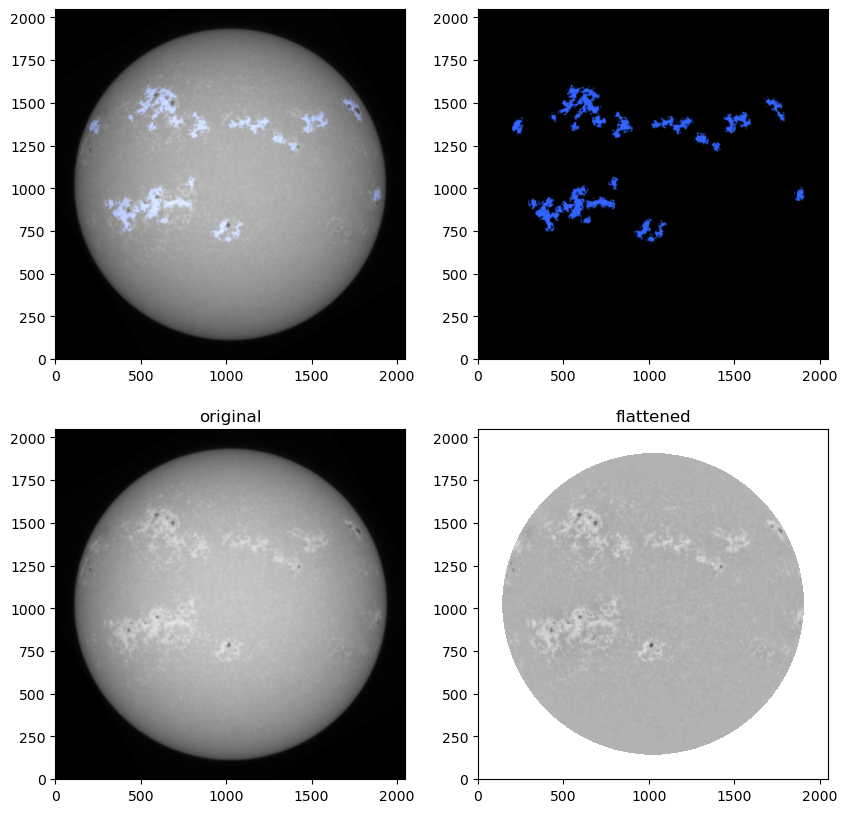

In [19]:
Ca_color = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
Ca_color[Ca_labels>0]=[50,100,255]

img8 = cv.convertScaleAbs(map.data, alpha=(255.0/65535.0)).astype(np.uint8)
img_Ca = cv.addWeighted(cv.cvtColor(img8, cv.COLOR_GRAY2RGB),3,Ca_color,0.3,0)

plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(img_Ca, origin='lower');

plt.subplot(222)
plt.imshow(Ca_color, origin='lower');

plt.subplot(223)
plt.imshow(map.data, origin='lower', cmap='grey')
plt.title('original');

plt.subplot(224)
plt.imshow(img, origin='lower', cmap='grey')
plt.title('flattened');